# A/B/C Testing Analysis: Fast-Food Promotion Effectiveness

## 1. Project Overview

This section will introduce the problem and the goal of our analysis.

### 1.1 Introduction
This project investigates the effectiveness of three distinct promotional strategies implemented by a fast-food chain. The primary objective is to determine which promotion resulted in the highest total sales per location and to provide data-driven recommendations for future marketing efforts. This analysis leverages A/B/C testing methodology to compare performance across different experimental groups.

### 1.2 Dataset Description
The dataset used for this analysis contains simulated sales data from a multi-week promotional campaign across various fast-food store locations. Key variables include:
* `MarketID`: Unique identifier for the market.
* `MarketSize`: Categorical classification of the market (Small, Medium, Large).
* `LocationID`: Unique identifier for each store location.
* `AgeOfStore`: Age of the store in years.
* `Promotion`: The specific promotion assigned to that store (1, 2, or 3).
* `week`: The week of sales data (1-4).
* `SalesInThousands`: Total sales for the store in that week, in thousands of dollars (our primary outcome variable).

### 1.3 Key Questions
This analysis aims to answer the following core questions:
* Are there statistically significant differences in sales performance among the three promotions?
* If so, which specific promotions are performing better or worse than others?
* What are the data-driven recommendations for the fast-food chain's future promotional strategy?

## 2. Project Setup & Library Imports

This section loads all necessary Python libraries required for data manipulation, statistical analysis, and visualization.

### 2.1 Library Imports
The following code block imports all essential Python libraries. `pandas` is used for data handling, `numpy` for numerical operations, `scipy.stats` and `statsmodels` for statistical tests (ANOVA and post-hoc), and `matplotlib.pyplot` alongside `seaborn` for data visualization. Standard display options are also set for cleaner output.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set a style for matplotlib/seaborn for nicer plots by default
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Set default figure size

## 3. Data Loading & Initial Inspection

This section focuses on loading the dataset and performing initial checks to understand its structure, identify missing values, and gain a preliminary sense of the data distributions.

### 3.1 Data Loading
The dataset, assumed to be in CSV format and located in the same directory as this notebook, is loaded into a pandas DataFrame. This DataFrame will be our primary object for all subsequent analysis.

In [3]:
df = pd.read_csv('FAST_FOOD_Marketing-Campaign.csv')

### 3.2 Initial Data Overview
A first look at the data's head, general information (data types, non-null counts), and descriptive statistics provides a quick overview. This helps confirm successful loading, identify data types, and check for basic summary statistics like mean, standard deviation, and value ranges. We also confirm the absence of null values and note the object type for `MarketSize` (which we previously decided to keep as categorical).

In [4]:
print("--- Initial Data Overview ---")
print(df.head())
print("\n--- DataFrame Information ---")
print(df.info())
print("\n--- Descriptive Statistics (All Columns) ---")
print(df.describe(include='all'))

--- Initial Data Overview ---
   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  

--- DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion    

### 3.3 Data Distribution Checks
Further checks are performed to understand the distribution of key categorical variables (`Promotion` and `MarketSize`) and to confirm the absence of null values across all columns. This helps ensure our experimental groups are reasonably balanced and that the data is complete.

In [5]:
print("\n--- Promotion Group Counts ---")
print(df['Promotion'].value_counts())
print("\n--- Market Size Counts ---")
print(df['MarketSize'].value_counts())
print("\n--- Null Values Check ---")
print(df.isnull().sum())


--- Promotion Group Counts ---
Promotion
3    188
2    188
1    172
Name: count, dtype: int64

--- Market Size Counts ---
MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

--- Null Values Check ---
MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64


## 4. Experiment Design & Hypothesis

This section outlines the setup of our A/B/C test and formally states the hypotheses we intend to test.

### 4.1 Experiment Setup
In this experiment, three distinct promotions (Promotion 1, Promotion 2, and Promotion 3) were presumably assigned to different store locations. The goal is to compare the sales performance under each promotion to identify the most effective strategy. Each location provided sales data for a period of four weeks while running its assigned promotion.

### 4.2 Primary Metric Definition
Our primary metric for evaluating promotion effectiveness is **"Total Sales per Location over Four Weeks."** This metric is derived by summing the `SalesInThousands` for each unique store location across its four weeks of recorded data. This aggregation ensures that each experimental unit (a store location) is represented by a single, comprehensive sales figure for the duration of the promotion.

### 4.3 Hypothesis Formulation
For this A/B/C test, we establish the following null and alternative hypotheses:
* **Null Hypothesis ($H_0$):** There is **no statistically significant difference** in the **mean total sales per location over four weeks** among Promotion 1, Promotion 2, and Promotion 3.
* **Alternative Hypothesis ($H_1$):** There **is a statistically significant difference** in the **mean total sales per location over four weeks** among Promotion 1, Promotion 2, and Promotion 3. (i.e., at least one promotion's mean sales differs from the others).

## 5. Data Preprocessing for Analysis

This section details the steps taken to transform the raw, weekly sales data into the aggregated format required for our primary metric, which is the total sales for each unique store location.

### 5.1 Aggregating Sales Data
To derive our primary metric, `Total Sales per Location over Four Weeks`, we group the original DataFrame by `LocationID` and sum the `SalesInThousands`. Subsequently, the `Promotion` assigned to each unique location is merged back into this aggregated DataFrame, as each location consistently ran only one promotion throughout the test period.

In [6]:
# Aggregate SalesInThousands by LocationID
location_sales = df.groupby('LocationID')['SalesInThousands'].sum().reset_index()

# Add the 'Promotion' each location received to this new dataframe
location_promotion_map = df.drop_duplicates(subset=['LocationID'])[['LocationID', 'Promotion']]
location_sales = pd.merge(location_sales, location_promotion_map, on='LocationID', how='left')

# Display head and info of the new aggregated DataFrame
print("--- Aggregated Sales Data (first 5 rows) ---")
print(location_sales.head())
print("\n--- Aggregated Sales Data Info ---")
print(location_sales.info())

--- Aggregated Sales Data (first 5 rows) ---
   LocationID  SalesInThousands  Promotion
0           1            137.68          3
1           2            118.18          2
2           3            162.72          1
3           4            134.83          2
4           5            116.01          2

--- Aggregated Sales Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LocationID        137 non-null    int64  
 1   SalesInThousands  137 non-null    float64
 2   Promotion         137 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 3.3 KB
None


### 5.2 Verifying Location Distribution by Promotion
After aggregation, it's crucial to confirm the number of unique locations assigned to each promotion. This step ensures that our experimental groups have reasonably balanced sample sizes, which is important for the validity and statistical power of our subsequent hypothesis test.

In [7]:
print("\n--- Unique Locations per Promotion ---")
print(location_sales['Promotion'].value_counts())


--- Unique Locations per Promotion ---
Promotion
3    47
2    47
1    43
Name: count, dtype: int64


## 6. Exploratory Data Analysis (EDA) & Covariate Balance Check

This section explores the aggregated data through visualizations and checks for balance in potential confounding variables (`MarketSize` and `AgeOfStore`) across the different promotion groups. This helps us understand underlying data patterns and assess the effectiveness of the experimental assignment.

### 6.1 Visualizing Sales Distributions
Visualizing the distribution of `Total Sales per Location` for each promotion group provides an intuitive understanding of their performance before formal statistical testing. Box plots are particularly useful for showing central tendency, spread, and potential outliers.

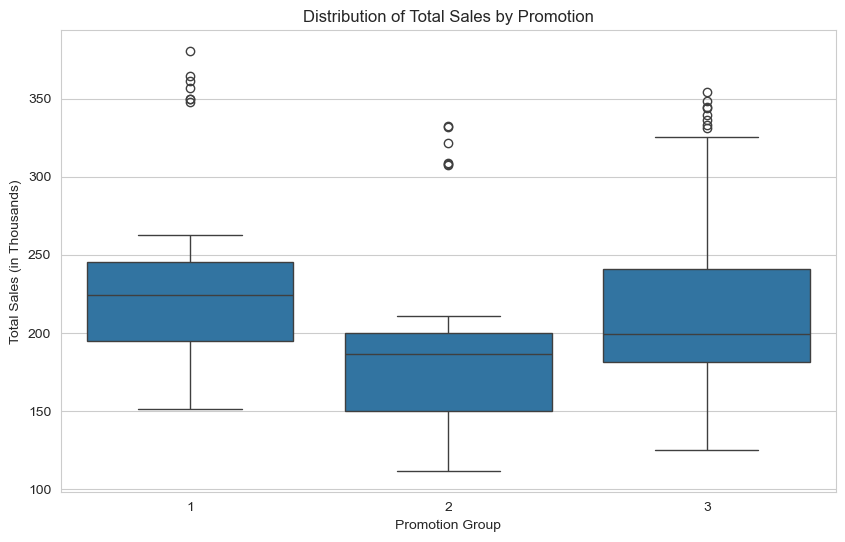

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=location_sales)
plt.title('Distribution of Total Sales by Promotion')
plt.xlabel('Promotion Group')
plt.ylabel('Total Sales (in Thousands)')
plt.show()

### 6.2 Checking Covariate Balance
We assess whether other key characteristics (`MarketSize` and `AgeOfStore`) are evenly distributed among the promotion groups. This is vital to ensure that any observed differences in sales are attributable to the promotions themselves, rather than pre-existing differences in store characteristics that could influence sales. Our initial checks noted a slight imbalance in `MarketSize` (Promotion 2 having a higher proportion of 'Large' markets and Promotion 3 having a lower proportion of 'Large' markets compared to others), which is an important consideration for result interpretation. `AgeOfStore`, however, appeared well-balanced.

In [9]:
print("--- MarketSize Distribution by Promotion (Proportions) ---")
print(df.groupby('Promotion')['MarketSize'].value_counts(normalize=True).unstack())
print("\n--- AgeOfStore Descriptive Statistics by Promotion ---")
print(df.groupby('Promotion')['AgeOfStore'].describe())

--- MarketSize Distribution by Promotion (Proportions) ---
MarketSize     Large    Medium     Small
Promotion                               
1           0.325581  0.558140  0.116279
2           0.340426  0.574468  0.085106
3           0.255319  0.617021  0.127660

--- AgeOfStore Descriptive Statistics by Promotion ---
           count      mean       std  min  25%  50%   75%   max
Promotion                                                      
1          172.0  8.279070  6.636160  1.0  3.0  6.0  12.0  27.0
2          188.0  7.978723  6.597648  1.0  3.0  7.0  10.0  28.0
3          188.0  9.234043  6.651646  1.0  5.0  8.0  12.0  24.0


## 7. Statistical Analysis (ANOVA)

This section performs the primary statistical test (ANOVA) to determine if there is an overall statistically significant difference in mean total sales across the three promotion groups.

### 7.1 Preparing for ANOVA
To ensure the `statsmodels` library correctly interprets `Promotion` as a categorical grouping variable, we explicitly convert its data type in our `location_sales` DataFrame.

In [11]:
location_sales['Promotion'] = location_sales['Promotion'].astype('category')

### 7.2 Running the ANOVA Model
An Analysis of Variance (ANOVA) model is fitted using `statsmodels.formula.api.ols`. The `model.summary()` provides comprehensive regression results, while `sm.stats.anova_lm()` extracts the specific ANOVA table. The key output to observe is the `PR(>F)` (p-value) for `C(Promotion)`, which will indicate the overall significance of the promotions' effect on sales.

In [12]:
model = ols('SalesInThousands ~ C(Promotion)', data=location_sales).fit()

print("--- OLS Regression Results (Full Model Summary) ---")
print(model.summary())

print("\n--- ANOVA Table (Overall Test) ---")
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

--- OLS Regression Results (Full Model Summary) ---
                            OLS Regression Results                            
Dep. Variable:       SalesInThousands   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     5.846
Date:                Fri, 13 Jun 2025   Prob (F-statistic):            0.00368
Time:                        11:10:27   Log-Likelihood:                -759.59
No. Observations:                 137   AIC:                             1525.
Df Residuals:                     134   BIC:                             1534.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

## 8. Post-Hoc Analysis

Since the ANOVA indicated an overall significant difference among the promotion groups, this section conducts post-hoc tests to pinpoint *which specific pairs* of promotions have statistically significant differences in their mean total sales. Tukey's HSD test is used to control the family-wise error rate across multiple comparisons.

### 8.1 Purpose of Post-Hoc Tests
The ANOVA test tells us *if* there's a difference somewhere among the groups, but not *where* that difference lies. Post-hoc tests are essential to perform pairwise comparisons (e.g., Promotion 1 vs. Promotion 2, Promotion 1 vs. Promotion 3, Promotion 2 vs. Promotion 3) while statistically adjusting for the increased risk of false positives when multiple comparisons are made. This helps to draw the "missing lines" of comparison between all promotion pairs.

### 8.2 Performing Tukey's HSD
Tukey's Honestly Significant Difference (HSD) test is applied using `statsmodels.stats.multicomp.pairwise_tukeyhsd`. This provides an adjusted p-value for each pair, allowing us to determine specific significant differences while controlling the family-wise error rate.

--- Tukey's HSD Post-Hoc Test Results ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -43.0784  0.004 -74.3806 -11.7762   True
     1      3 -10.9382 0.6862 -42.2404   20.364  False
     2      3  32.1402 0.0371   1.5415  62.7389   True
------------------------------------------------------


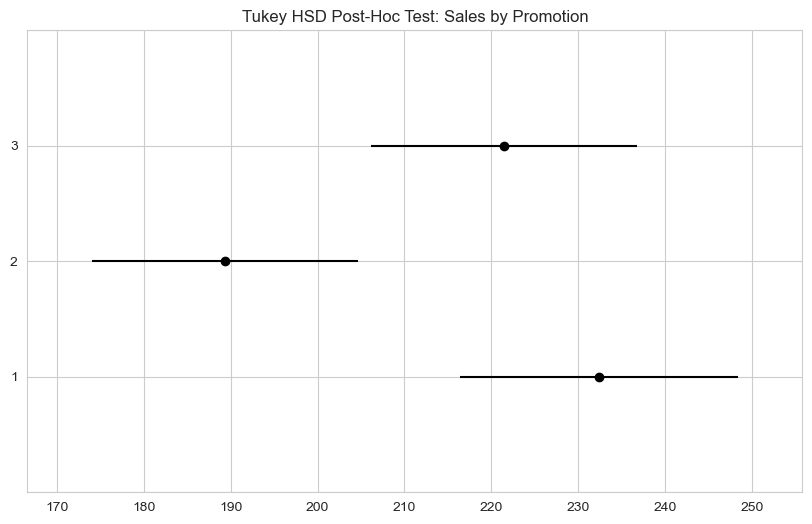

In [14]:
tukey_result = pairwise_tukeyhsd(endog=location_sales['SalesInThousands'],
                                 groups=location_sales['Promotion'],
                                 alpha=0.05)

print("--- Tukey's HSD Post-Hoc Test Results ---")
print(tukey_result)

# Plotting the Tukey HSD results visually shows the confidence intervals for differences
tukey_result.plot_simultaneous()
plt.title("Tukey HSD Post-Hoc Test: Sales by Promotion")
plt.show()

## 9. Results Interpretation & Discussion

This section synthesizes the findings from the statistical tests, providing clear conclusions about the performance of each promotion.

### 9.1 Overall ANOVA Findings
Based on the ANOVA table's `PR(>F)` (p-value) for `C(Promotion)` (0.003681), which is **less than our significance level of 0.05**, we **reject the null hypothesis ($H_0$)**. This implies that there *is a statistically significant difference* in the mean total sales per location over four weeks among Promotion 1, Promotion 2, and Promotion 3. This indicates that the choice of promotion does have a measurable impact on sales.

### 9.2 Pairwise Comparison Insights
The Tukey HSD post-hoc test provided detailed insights into the specific differences between each pair of promotions:
* **Promotion 1 vs. Promotion 2:** The mean total sales for Promotion 1 were approximately **$43,078 higher** than for Promotion 2 (`meandiff = -43.0784`). With an adjusted p-value (`p-adj`) of **0.004**, which is less than 0.05, this difference is **statistically significant (`reject = True`)**.
* **Promotion 1 vs. Promotion 3:** The mean total sales for Promotion 1 were approximately **$10,938 higher** than for Promotion 3 (`meandiff = -10.9382`). However, with an adjusted p-value (`p-adj`) of **0.6862**, which is much greater than 0.05, this difference is **not statistically significant (`reject = False`)**. The observed difference could plausibly be due to random chance.
* **Promotion 2 vs. Promotion 3:** The mean total sales for Promotion 3 were approximately **$32,140 higher** than for Promotion 2 (`meandiff = 32.1402`). With an adjusted p-value (`p-adj`) of **0.0371**, which is less than 0.05, this difference is **statistically significant (`reject = True`)**.

### 9.3 Summary of Promotion Performance
Consolidating these findings, we can conclude:
* **Promotion 1** and **Promotion 3** performed statistically similarly in terms of total sales per location. Neither was significantly better than the other.
* **Promotion 2** performed **significantly worse** than both Promotion 1 and Promotion 3.

This indicates that while Promotion 1 and 3 are both effective strategies for driving sales, Promotion 2 is demonstrably less effective.

## 10. Recommendations & Limitations

This final section offers actionable business recommendations based on the analysis, acknowledges any limitations of the study, and suggests avenues for future research.

### 10.1 Key Recommendations
Based on the comprehensive statistical analysis of sales performance:
* The fast-food chain should definitively **avoid Promotion 2** as it leads to significantly lower sales compared to the other two promotions.
* The chain should **focus on implementing either Promotion 1 or Promotion 3**. Since no statistically significant difference in sales performance was found between these two, the decision should be guided by other business factors (see limitations below), such as cost, ease of implementation, or specific marketing goals.

### 10.2 Limitations of the Analysis
It is important to acknowledge the inherent limitations of this analysis, which impact the scope and generalizability of the conclusions:
* **Missing Cost Data:** This analysis focused solely on sales volume. The profitability of each promotion (i.e., its cost versus the sales generated) is a crucial business factor not included in this dataset. A promotion with slightly lower sales but significantly lower costs might be more profitable.
* **Short Duration:** The sales data covers only four weeks. This short-term view does not allow for assessment of long-term effects, customer loyalty, or potential "fad" impacts that might not be sustainable.
* **External Factors:** Unmeasured external factors (e.g., specific local events, competitor promotional activities, or seasonal trends beyond the four-week period) could have influenced sales and were not controlled for.
* **Covariate Imbalance:** While the experiment was generally well-balanced, a slight imbalance in `MarketSize` was noted across promotion groups. While not severely impacting our direct comparison, in more complex analyses or if the imbalance were greater, this could potentially confound results if not explicitly controlled for.
* **Generalizability:** The results are based on a sample of stores and might not perfectly generalize to all locations, different time periods, or future campaigns without further validation.

### 10.3 Future Work
To provide even more comprehensive and robust recommendations, future work could include:
* **Cost-Benefit Analysis:** Incorporating the financial cost associated with implementing each promotion to determine which offers the best return on investment (ROI).
* **Longer-Term Tracking:** Conducting a longer A/B test (e.g., 8-12 weeks) to understand the sustained impact of promotions on sales and customer behavior.
* **Advanced Modeling:** Employing more sophisticated statistical models (e.g., ANCOVA, regression with categorical predictors, or mixed-effects models if longitudinal store data is available) to explicitly control for covariates like `MarketSize` and `AgeOfStore`.
* **Qualitative Research:** Gathering feedback from store managers on operational challenges, and from customers on promotion appeal and satisfaction.
* **Targeted A/B Test:** If Promotions 1 and 3 are deemed comparable in terms of cost and operational feasibility, a dedicated A/B test comparing only these two promotions could be designed to potentially uncover a smaller, yet significant, difference if one truly exists with a larger sample or longer duration.